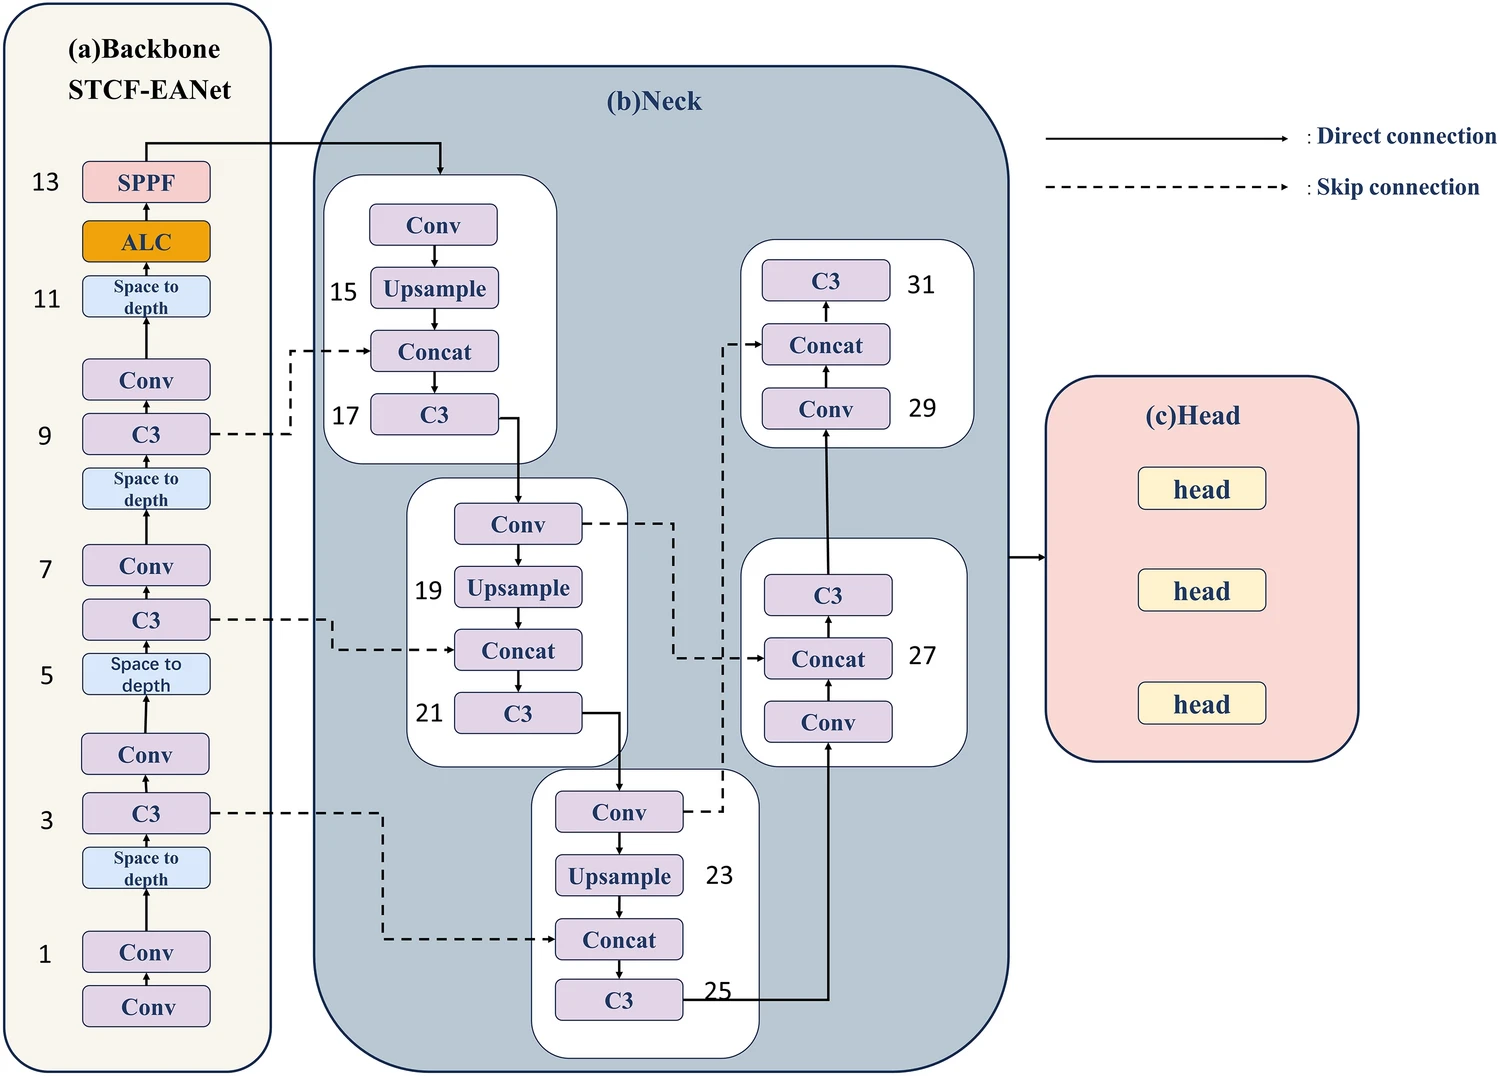



In [1]:
import torch
import torch.nn as nn

In [2]:
class SpaceToDepth(nn.Module):
    def __init__(self, block_size=2):
        super(SpaceToDepth, self).__init__()
        self.block_size = block_size

    def forward(self, x):
        N, C, H, W = x.size()
        assert H % self.block_size == 0 and W % self.block_size == 0
        new_C = C * (self.block_size ** 2)
        new_H = H // self.block_size
        new_W = W // self.block_size
        x = x.view(N, C, new_H, self.block_size, new_W, self.block_size)
        x = x.permute(0, 1, 3, 5, 2, 4).contiguous()
        x = x.view(N, new_C, new_H, new_W)
        return x

In [3]:
# Define the Bottleneck module
class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, shortcut=True):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.shortcut = shortcut
        if self.shortcut:
            self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.shortcut:
            out += self.conv3(identity)
        return out

# Define the C3 module
class C3(nn.Module):
    def __init__(self, in_channels, out_channels, num_bottlenecks=3):
        super(C3, self).__init__()
        self.bottlenecks = nn.ModuleList()
        self.bottlenecks.append(Bottleneck(in_channels, out_channels))
        for _ in range(1, num_bottlenecks):
            self.bottlenecks.append(Bottleneck(out_channels, out_channels))

    def forward(self, x):
        for bottleneck in self.bottlenecks:
            x = bottleneck(x)
        return x



In [4]:
class AttentionLePE(nn.Module):
    def __init__(self, channels, num_heads=4):
        super(AttentionLePE, self).__init__()
        self.num_heads = num_heads
        self.qkv = nn.Conv2d(channels, channels * 3, kernel_size=1, bias=False)
        self.attention = nn.MultiheadAttention(channels, num_heads)
        self.proj = nn.Conv2d(channels, channels, kernel_size=1, bias=False)

    def forward(self, x):
        N, C, H, W = x.shape
        qkv = self.qkv(x).reshape(N, 3, self.num_heads, C // self.num_heads, H, W)
        q, k, v = qkv.unbind(dim=1)
        q = q.flatten(3).permute(2, 0, 1, 3).reshape(-1, N, C)
        k = k.flatten(3).permute(2, 0, 1, 3).reshape(-1, N, C)
        v = v.flatten(3).permute(2, 0, 1, 3).reshape(-1, N, C)
        out, _ = self.attention(q, k, v)
        out = out.reshape(H, W, N, C).permute(2, 3, 0, 1).contiguous()
        out = self.proj(out)
        return out



In [5]:
class SPPF(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SPPF, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=9, stride=1, padding=4)
        self.pool3 = nn.MaxPool2d(kernel_size=13, stride=1, padding=6)
        self.conv2 = nn.Conv2d(out_channels * 4, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.conv1(x)
        p1 = self.pool1(x)
        p2 = self.pool2(x)
        p3 = self.pool3(x)
        out = torch.cat([x, p1, p2, p3], dim=1)
        out = self.conv2(out)
        return out


In [6]:
class STCF_EANet(nn.Module):
    def __init__(self):
        super(STCF_EANet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.s2d_1 = SpaceToDepth(block_size=2)
        self.c3_1 = C3(256, 128)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)
        self.s2d_2 = SpaceToDepth(block_size=2)
        self.c3_2 = C3(512, 256)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1)
        self.s2d_3 = SpaceToDepth(block_size=2)
        self.c3_3 = C3(1024, 512)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.s2d_4 = SpaceToDepth(block_size=2)
        self.alc = AttentionLePE(2048)
        self.sppf = SPPF(2048, 512)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.s2d_1(x)
        x = self.c3_1(x)
        skip1= x
        x = self.conv3(x)
        x = self.s2d_2(x)
        x = self.c3_2(x)
        skip2 = x
        x = self.conv4(x)
        x = self.s2d_3(x)
        x = self.c3_3(x)
        skip3 = x
        x = self.conv5(x)
        x = self.s2d_4(x)
        x = self.alc(x)
        x = self.sppf(x)
        return x, [skip3, skip2, skip1]

In [7]:
class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(Conv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))


In [8]:
class Upsample(nn.Module):
    def __init__(self, scale_factor=2, mode='nearest'):
        super(Upsample, self).__init__()
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode=mode)

    def forward(self, x):
        return self.upsample(x)


In [9]:
class Neck(nn.Module):
    def __init__(self):
          super(Neck, self).__init__()
          self.conv1 = Conv(512, 256, kernel_size=1, stride=1, padding=0)
          self.upsample1 = Upsample()
          self.c3_1 = C3(768, 256)  # First C3 block after concatenation (512 from upsampled + 256 from skip1)

          self.conv2 = Conv(256, 128, kernel_size=1, stride=1, padding=0)
          self.upsample2 = Upsample(scale_factor=4)
          self.c3_2 = C3(384, 128)  # Second C3 block after concatenation (256 from upsampled + 128 from skip2)

          self.conv3 = Conv(128, 64, kernel_size=1, stride=1, padding=0)
          self.upsample3 = Upsample(scale_factor=4)
          self.c3_3 = C3(192, 64)  # Third C3 block after concatenation (128 from upsampled + 64 from skip3)

          self.conv4 = Conv(64, 32, kernel_size=1, stride=1, padding=0)
          self.c3_4 = C3(160, 32)  # Fourth C3 block after concatenation (64 from conv4 + 32 from skip4)

          self.conv5 = Conv(32, 32, kernel_size=1, stride=1, padding=0)
          self.c3_5 = C3(96, 32)  # Fifth C3 block after concatenation (32 from conv5 + 32 from skip5)

    def forward(self, x, skip_connections):
        x = self.conv1(x)
        x = self.upsample1(x)
        x = torch.cat([x, skip_connections[0]], dim=1)  # Concatenation with skip connection 1 (from c3_3 in STCF_EANet)
        x = self.c3_1(x)

        x = self.conv2(x)
        skip4 = x
        x = self.upsample2(x)
        x = torch.cat([x, skip_connections[1]], dim=1)  # Concatenation with skip connection 2 (from c3_2 in STCF_EANet)
        x = self.c3_2(x)

        x = self.conv3(x)
        skip5 = x
        x = self.upsample3(x)
        x = torch.cat([x, skip_connections[2]], dim=1)  # Concatenation with skip connection 3 (from c3_1 in STCF_EANet)
        x = self.c3_3(x)

        x = self.conv4(x)
        skip4 = self.upsample2(skip4)
        skip4 = self.upsample3(skip4)
        x = torch.cat([x, skip4], dim=1)  # Concatenation with skip connection 4 (from conv2 in Neck)
        x = self.c3_4(x)

        x = self.conv5(x)
        skip5 = self.upsample3(skip5)
        x = torch.cat([x, skip5], dim=1)  # Concatenation with skip connection 5 (from conv3 in Neck)
        x = self.c3_5(x)

        return x


In [10]:
class Head(nn.Module):
    def __init__(self, in_channels, num_classes, num_anchors):
        super(Head, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels, num_anchors * (num_classes + 5), kernel_size=1, stride=1, padding=0)
        self.num_classes = num_classes
        self.num_anchors = num_anchors

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        batch_size, _, height, width = x.shape
        x = x.view(batch_size, self.num_anchors, self.num_classes + 5, height, width)
        x = x.permute(0, 1, 3, 4, 2).contiguous()
        return x



In [11]:
class FocusDet(nn.Module):
    def __init__(self, num_classes, num_anchors):
        super(FocusDet, self).__init__()
        self.backbone = STCF_EANet()
        self.neck = Neck()
        self.head = Head(32, num_classes, num_anchors)

    def forward(self, x):
        # Pass through the backbone and collect skip connections
        x, skip_connections = self.backbone(x)

        # Pass through the neck
        neck_output = self.neck(x, skip_connections)

        # Pass through the head
        head_output = self.head(neck_output)

        return head_output


In [12]:
# Define the model with a number of classes and anchors
num_classes = 1 # Example number of classes
num_anchors = 3    # Example number of anchors

# Initialize the model
model = FocusDet(num_classes, num_anchors).to("cuda")

# Create a dummy input tensor (batch size, channels, height, width)
dummy_input = torch.randn(1, 3, 640, 640).to('cuda') # Example input size

# Run a forward pass
output = model(dummy_input)

# Check the output shape
print("Final Output shape:", output.shape)


Final Output shape: torch.Size([1, 3, 160, 160, 6])


In [13]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn.functional as F
import torchvision.transforms as transforms

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Dataset and DataLoader
class YOLODataset(Dataset):
    def __init__(self, images_folder, labels_folder, image_size=640, transform=None):
        self.images_folder = images_folder
        self.labels_folder = labels_folder
        self.image_size = image_size
        self.image_files = [f for f in os.listdir(images_folder) if os.path.isfile(os.path.join(images_folder, f))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # print(f"Loading index: {idx}")
        image_path = os.path.join(self.images_folder, self.image_files[idx])
        label_path = os.path.join(self.labels_folder, os.path.splitext(self.image_files[idx])[0] + ".txt")
        # print(f"Image path: {image_path}, Label path: {label_path}")

        # Load image
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        # print(f"Loaded image shape: {image.shape}")

        # Load labels
        boxes = []
        with open(label_path, 'r') as f:
            for line in f:
                line = line.strip()
                if line:
                    class_id, x_center, y_center, width, height = map(float, line.split())
                    boxes.append([class_id, x_center, y_center, width, height])
                else:
                    boxes.append([0, 0, 0, 0, 0])
                
        boxes = torch.tensor(boxes)
        # print(f"Loaded boxes for index {idx}, shape: {boxes.shape}")
        return image, boxes

transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
])

train_dataset = YOLODataset(images_folder="data_full/train/images", labels_folder="data_full/train/labels", transform=transform)
val_dataset = YOLODataset(images_folder="data_full/val/images", labels_folder="data_full/val/labels", transform=transform)

def collate_fn(batch):
    images, targets = list(zip(*batch))
    images = torch.stack(images, dim=0)
    max_len = max(len(t) for t in targets)
    padded_targets = []
    for t in targets:
        padded_t = torch.zeros((max_len, 5))
        padded_t[:len(t), :] = t
        padded_targets.append(padded_t)
    targets = torch.stack(padded_targets, dim=0)
    return images, targets

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0, collate_fn=collate_fn)

# Print the total number of images in train and val datasets
print(f"Total number of images in train dataset: {len(train_dataset)}")
print(f"Total number of images in val dataset: {len(val_dataset)}")

c:\Users\jesli\anaconda3\envs\pv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda
Total number of images in train dataset: 19204
Total number of images in val dataset: 865


In [14]:

from tqdm import tqdm
import torch.optim as optim

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [15]:
def yolo_loss(preds, targets):
    batch_size, _, grid_size, _, _ = preds.shape

    # Create new target tensors with the same shape as predictions
    new_target_boxes = torch.zeros_like(preds[..., 1:5]).to(device)
    new_target_obj = torch.zeros_like(preds[..., 0]).to(device)
    new_target_class = torch.zeros_like(preds[..., 5:]).to(device)

    for i in range(batch_size):
        for box in targets[i]:
            if box.sum() == 0:  # Skip padding and handle no objects case
                continue

            # Calculate which grid cell this ground truth box belongs to
            grid_x = int(box[1] * grid_size)
            grid_y = int(box[2] * grid_size)

            # Update the corresponding elements in the new target tensors
            new_target_boxes[i, :, grid_y, grid_x] = box[1:5]
            new_target_obj[i, :, grid_y, grid_x] = 1
            new_target_class[i, :, grid_y, grid_x] = box[0]

    # Now calculate losses using the reshaped targets
    bbox_loss = F.mse_loss(preds[..., 1:5], new_target_boxes)
    obj_loss = F.mse_loss(preds[..., 0], new_target_obj)
    class_loss = F.cross_entropy(preds[..., 5:].view(-1, preds.size(-1)-5), new_target_class.long().view(-1))

    return bbox_loss + obj_loss + class_loss

def train_fn(train_loader, model, optimizer, loss_fn, device):
    model.train()
    loop = tqdm(train_loader, leave=True)
    for batch_idx, (data, targets) in enumerate(loop):
        # print(f"Batch {batch_idx} start")
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass
        predictions = model(data)
        # print(f"Batch {batch_idx} forward pass done")
        loss = loss_fn(predictions, targets)
        # print(f"Batch {batch_idx} loss calculated")

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update progress bar
        loop.set_postfix(loss=loss.item())
        # print(f"Batch {batch_idx} end")

In [1]:
def eval_fn(val_loader, model, loss_fn, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(val_loader):
            data = data.to(device)
            targets = targets.to(device)

            predictions = model(data)
            loss = loss_fn(predictions, targets)
            losses.append(loss.item())

    mean_loss = sum(losses) / len(losses)
    print(f"Validation Loss: {mean_loss:.4f}")
    return mean_loss


In [16]:
# Training loop
num_epochs = 2
best_loss = float("inf")
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    train_fn(train_loader, model, optimizer, yolo_loss, device)
    val_loss = eval_fn(val_loader, model, yolo_loss, device)

    # Save model checkpoint
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")

# Save final model
torch.save(model.state_dict(), "final_model.pth")

Epoch 1/2


  3%|▎         | 72/2401 [00:42<22:46,  1.70it/s, loss=0.000282]


KeyboardInterrupt: 

In [1]:
import torch
print(torch.cuda.is_available())


True
